# Speaker Identification

Text(0.5, 0, 'Number of Speakers')

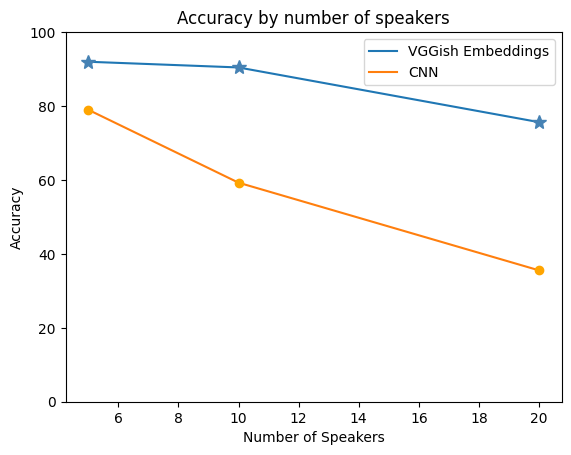

In [2]:
import math
import random
import numpy as np
import librosa
import matplotlib.pyplot as plt

fivevgg = [0.94447660,0.95706898,0.95934319,0.94880545,0.32394856,0.96585649,0.95991272,0.95634270,0.96104479,0.90679061,0.92205840,0.95092440,0.92154872,0.95683944,0.95309526,0.94056165,0.94644040,0.90275872,0.96498823,0.93177980,0.93074518,0.94423437,0.96645796,0.92889559,0.95119870]
tenvgg = [0.90047634,0.85916662,0.88760287,0.91713089,0.88994265,0.91689712,0.92651540,0.91207546,0.91933054,0.90255326,0.93229455,0.88642770,0.91912723,0.92506468,0.94099718,0.90749002,0.90065914,0.91762137,0.87230527,0.87131679,0.89855266,0.87554008,0.92138267,0.89781547,0.91194147]
twentyvgg = [0.54047787,0.83028978,0.86905277,0.84565496,0.50137204,0.84981763,0.85792303]
fivecnn = [76.5886287625418, 74.32216905901116, 86.10271903323263]
tencnn = [63.9344262295082, 61.40295690468701, 51.57248157248157, 60.14833127317676]
twentycnn = [35.53467808786958]
import statistics as s
avgvgg = [s.mean(fivevgg) * 100, s.mean(tenvgg) * 100, s.mean(twentyvgg) * 100]
avgcnn = [s.mean(fivecnn), s.mean(tencnn), s.mean(twentycnn)]
fig, axs = plt.subplots()
plt.plot([5,10,20], avgvgg)
plt.plot([5,10,20], avgcnn)
plt.plot([5,10,20], avgvgg, '*', color='steelblue', markersize=10)
plt.plot([5,10,20], avgcnn, 'o', color='orange')
plt.ylim(0,100)
# axs.set_title('Accuracy of VGGish Embeddings with SVM classifier')
axs.set_title('Accuracy by number of speakers')
axs.legend(['VGGish Embeddings', 'CNN'])
axs.set_ylabel('Accuracy')
axs.set_xlabel('Number of Speakers')

In [4]:
fivefft_train = [0.9731, 0.9439, 0.9915]
fivefft_val = [0.8586, 0.6735, 0.8205]
fivemfcc_train = [0.9359, 0.9712, 0.9979]
fivemfcc_val = [0.5455, 0.5692, 0.6102]

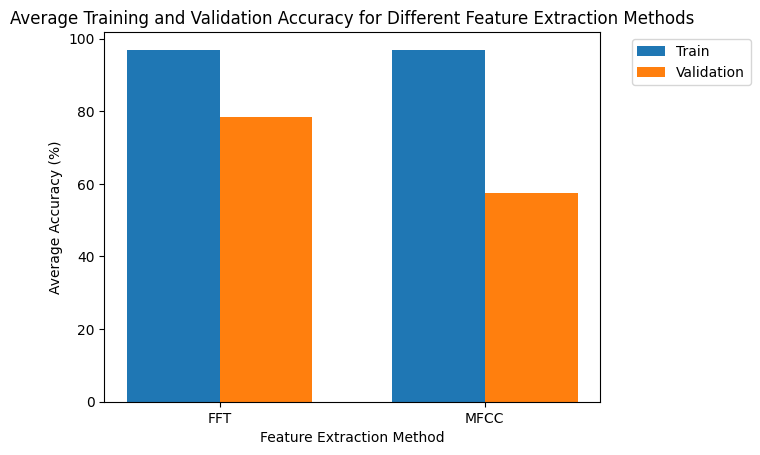

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Data
fivefft_train = [0.9731, 0.9439, 0.9915]
fivefft_val = [0.8586, 0.6735, 0.8205]
fivemfcc_train = [0.9359, 0.9712, 0.9979]
fivemfcc_val = [0.5455, 0.5692, 0.6102]

# Calculate averages
avg_fivefft_train = np.mean(fivefft_train)
avg_fivemfcc_train = np.mean(fivemfcc_train)
avg_fivefft_val = np.mean(fivefft_val)
avg_fivemfcc_val = np.mean(fivemfcc_val)

# Normalize to percentage
avg_fivefft_train *= 100
avg_fivemfcc_train *= 100
avg_fivefft_val *= 100
avg_fivemfcc_val *= 100

# Plotting
bar_width = 0.35
index = np.arange(2)  # Two feature extraction methods

fig, ax = plt.subplots()

# Plotting training bars
ax.bar(index - bar_width/2, [avg_fivefft_train, avg_fivemfcc_train], bar_width, label='Train')

# Plotting validation bars
ax.bar(index + bar_width/2, [avg_fivefft_val, avg_fivemfcc_val], bar_width, label='Validation')

# Customize the plot
ax.set_xlabel('Feature Extraction Method')
ax.set_ylabel('Average Accuracy (%)')
ax.set_title('Average Training and Validation Accuracy for Different Feature Extraction Methods')
ax.set_xticks(index)
ax.set_xticklabels(['FFT', 'MFCC'])

# Move legend outside the graph
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


## Installation & Imports

In [ ]:
!pip3 install tensorflow==2.8.0
!pip3 install tensorflow-io==0.25.0

### Project imports

In [ ]:
import sys
import os
import random
from datetime import datetime
from pathlib import Path
from typing import Tuple

import librosa
import numpy as np
import keras
import matplotlib.pyplot as plt
from matplotlib import cm

import tensorflow as tf
import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
print("TensorFlow IO version:", tfio.__version__)
tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())
%load_ext tensorboard

TensorFlow version: 2.8.0
TensorFlow IO version: 0.25.0
True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
ROOT_DIR='/content/drive/MyDrive/College/Research/Linh_2023_Research'

DATASET_PATH=ROOT_DIR+'/test_data/vox'

Mounted at /content/drive


## Data Processing
[Keras Speaker Recognition](https://keras.io/examples/audio/speaker_recognition_using_cnn/)

In [ ]:
SAMPLING_RATE = 16000

def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio

### FFT & MFCC Pre-processing

In [ ]:
N_MFCC = 13

def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])

def audio_to_mfcc(audio):
    audio = tf.squeeze(audio, axis=-1)
    # Convert the audio to MFCC
    stfts = tf.signal.stft(audio, frame_length=1024, frame_step=256, fft_length=1024)
    spectrograms = tf.abs(stfts)

    # Warp the linear scale spectrograms into the mel-scale
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz = 80.0, 7600.0
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        N_MFCC, num_spectrogram_bins, SAMPLING_RATE, lower_edge_hertz, upper_edge_hertz)
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms and take the first N_MFCC
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :N_MFCC]
    print(mfccs.shape)

    return mfccs

### [VGGish Embedding Colab](https://colab.research.google.com/drive/1E3CaPAqCai9P9QhJ3WYPNCVmrJU4lAhF)

Tensorflow implementation of VGGish model takes `numpy` array as input. While this is possible in eager mode (default mode of Tensorflow 2.x), we cannot run VGGish model in a dataset mapping function as mapping functions do not run in eager model.

In [ ]:
!pip install numpy scipy
!pip install resampy tensorflow
!pip install tf_slim
!rm -rf models
!git clone https://github.com/tensorflow/models.git

In [ ]:
# Check to see where are in the kernel's file system.
!pwd

/content


In [ ]:
# Grab the VGGish model
!curl -O https://storage.googleapis.com/audioset/vggish_model.ckpt
!curl -O https://storage.googleapis.com/audioset/vggish_pca_params.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  277M  100  277M    0     0  98.8M      0  0:00:02  0:00:02 --:--:-- 98.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73020  100 73020    0     0   156k      0 --:--:-- --:--:-- --:--:--  156k


In [ ]:
# Make sure we got the model data.
!ls

drive		 requirements.txt	   vggish_model.ckpt	  vggish_smoke_test.py
mel_features.py  sample_data		   vggish_params.py	  vggish_train_demo.py
models		 vggish_export_tfhub.py    vggish_pca_params.npz
__pycache__	 vggish_inference_demo.py  vggish_postprocess.py
README.md	 vggish_input.py	   vggish_slim.py


In [ ]:
# Verify the location of the AudioSet source files
!ls models/research/audioset/vggish

mel_features.py   vggish_export_tfhub.py    vggish_params.py	   vggish_smoke_test.py
README.md	  vggish_inference_demo.py  vggish_postprocess.py  vggish_train_demo.py
requirements.txt  vggish_input.py	    vggish_slim.py


In [ ]:
# Copy the source files to the current directory.
!cp models/research/audioset/vggish/* .

In [ ]:
# Make sure the source files got copied correctly.
!ls

drive		 requirements.txt	   vggish_model.ckpt	  vggish_smoke_test.py
mel_features.py  sample_data		   vggish_params.py	  vggish_train_demo.py
models		 vggish_export_tfhub.py    vggish_pca_params.npz
__pycache__	 vggish_inference_demo.py  vggish_postprocess.py
README.md	 vggish_input.py	   vggish_slim.py


In [ ]:
# Run the test, which also loads all the necessary functions.
from vggish_smoke_test import *

In [ ]:
import vggish_slim
import vggish_params
import vggish_input

def create_vggish_net(sess, hop_size=0.96):   # Hop size is in seconds.
    """Define VGGish model, load the checkpoint, and return a dictionary that points
    to the different tensors defined by the model.
    """
    vggish_slim.define_vggish_slim()
    checkpoint_path = 'vggish_model.ckpt'
    vggish_params.EXAMPLE_HOP_SECONDS = hop_size

    vggish_slim.load_vggish_slim_checkpoint(sess, checkpoint_path)

    features_tensor = sess.graph.get_tensor_by_name(vggish_params.INPUT_TENSOR_NAME)
    embedding_tensor = sess.graph.get_tensor_by_name(vggish_params.OUTPUT_TENSOR_NAME)

    layers = {'conv1': 'vggish/conv1/Relu',
            'pool1': 'vggish/pool1/MaxPool',
            'conv2': 'vggish/conv2/Relu',
            'pool2': 'vggish/pool2/MaxPool',
            'conv3': 'vggish/conv3/conv3_2/Relu',
            'pool3': 'vggish/pool3/MaxPool',
            'conv4': 'vggish/conv4/conv4_2/Relu',
            'pool4': 'vggish/pool4/MaxPool',
            'fc1': 'vggish/fc1/fc1_2/Relu',
            # 'fc2': 'vggish/fc2/Relu',
            'embedding': 'vggish/embedding',
            'features': 'vggish/input_features',
            }
    g = tf.compat.v1.get_default_graph()
    for k in layers:
        layers[k] = g.get_tensor_by_name( layers[k] + ':0')

    return {'features': features_tensor,
            'embedding': embedding_tensor,
            'layers': layers,
            }

@tf.function
def embeddings_from_vggish(sess, vgg, x, sr=SAMPLING_RATE):
    """Run the VGGish model, starting with a sound (x) at sample rate
    (sr). Return a dictionary of embeddings from the different layers
    of the model."""
    # Produce a batch of log mel spectrogram examples.
    def waveform_to_examples_py(x_np, sr):
        x_np = np.array(x_np)
        return vggish_input.waveform_to_examples(x_np, sr)

    # Use tf.py_function to execute the Python function
    input_batch = tf.py_function(waveform_to_examples_py, [x, sr], tf.float32)

    layer_names = vgg['layers'].keys()
    tensors = [vgg['layers'][k] for k in layer_names]

    def concrete_func(x, sr):
        return sess.run(tensors, feed_dict={vgg['features']: x})

    # Execute the concrete function with the input tensor evaluated
    results = concrete_func(input_batch, sr)

    resdict = {}
    for i, k in enumerate(layer_names):
        resdict[k] = results[i]

    embedding = tf.convert_to_tensor(resdict['embedding'])
    return embedding

# Define the graph and load the model
with tf.Graph().as_default():
    sess = tf.compat.v1.Session()
    vgg = create_vggish_net(sess, 0.01)

# Iterate through dataset
# ...

# Close the session when done
sess.close()

### SpeechIdentity

In [ ]:
!git clone https://github.com/douglas125/SpeechIdentity.git

Cloning into 'SpeechIdentity'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 55 (delta 11), reused 23 (delta 0), pack-reused 0
Receiving objects: 100% (55/55), 8.66 MiB | 1.60 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [ ]:
!cp -r /content/SpeechIdentity/speech-id-model-110/ .
!ls

drive  sample_data  SpeechIdentity  speech-id-model-110


In [ ]:
import train_speech_id_model

model = tf.keras.models.load_model('speech-id-model-110')
cur_data = tfio.audio.AudioIOTensor(file)
audio_data = cur_data.to_tensor()[:, 0]
# set batch size to 1, extract first element
audio_embedding = model.predict(
	tf.expand_dims(audio_data, axis=0)
)[0]

### SpeechT5

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install datasets
!pip install sentencepiece

In [ ]:
!pip install transformers

In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForSpeechToText

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_asr")
model = SpeechT5ForSpeechToText.from_pretrained("microsoft/speecht5_asr")

### Dataset preparation

Create dataset

In [ ]:
BATCH_SIZE = 128
SHUFFLE_SEED = 43
TRAIN_VALID_SPLIT = 0.2
EPOCHS = 100
N_CLASS = 5

class_names = os.listdir(DATASET_PATH)
random.shuffle(class_names)
audio_paths = []
labels = []
for label, name in enumerate(class_names):
    if label > N_CLASS - 1: break
    print("Processing speaker {}".format(name,))
    dir_path = Path(DATASET_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Split into training and validation
num_val_samples = int(TRAIN_VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)

Processing speaker id10004
Processing speaker id10836
Processing speaker id10964
Processing speaker id10365
Processing speaker id10022
Found 699 files belonging to 395 classes.
Using 560 files for training.
Using 139 files for validation.


Data transformation

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

Data visualization (MFCC)

In [ ]:
# for i, data in enumerate(train_ds):
#     if i > 0: break
#     x, y = data
#     # Extract the chosen sample
#     selected_sample_np = x[i].numpy()

#     # Display the MFCC for the selected sample
#     plt.imshow(selected_sample_np, cmap='viridis', origin='lower', aspect='auto')
#     plt.title(f'MFCC for Sample {i}')
#     plt.xlabel('MFCC Coefficient')
#     plt.ylabel('Time Step')
#     plt.colorbar(label='Magnitude')
#     plt.show()


## Model

MFCC

FFT (focus on low freq) ---> CNN (max pool in one direction)

Is speaker unique in consonant or vowel?

To try: Cifar, Transfer learning

### Simple ResNet

In [ ]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def simple_resnet(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.Flatten()(x)
    # x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
# model = simple_resnet((SAMPLING_RATE//2, 1), N_CLASS)
model = simple_resnet((59, N_MFCC), N_CLASS)

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

## Training

`fit()` is for training the model with the given inputs (and corresponding training labels).

`evaluate()` is for evaluating the already trained model using the validation (or test) data and the corresponding labels. Returns the loss value and metrics values for the model.

`predict()` is for the actual prediction. It generates output predictions for the input samples.

In [ ]:
# Define the Keras TensorBoard callback
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb, tensorboard_callback],
)

In [ ]:
%tensorboard --logdir logs

## Evaluate

In [ ]:
print(model.evaluate(valid_ds))

In [ ]:
print(model.predict(valid_ds))